# Lab 2: Classification
### Danny Murphy, Kerry Nakayama, Brandon Tarr

### Introduction
We've followed a very natural data evolution from Lab 1 where we first started reducing the dataset to a more manageable and relevant size by focusing on bookings only and a five class (rather than 100 class) classification task. In the mini lab we fine-tuned our imputation and started experimenting with logistic regression and SVM classification given the attributes that Expedia provided as well as a handful we created ourselves. Neither of these methods were particularly accurate (~36%) at classifying the targeted hotel cluster so now we turn to three new algorithms to attempt to raise our classification accuracy: AdaBoostClassifier, ExtraTreesClassifier, and RandomForestClassifier. These will also be used to attempt a regression exercise on booking_window (one of our added features) to see if we can predict when a user's ideal search window might be for more targeted solicitation.
### Sources:
We make extensive use of the code provided for the Grand Poobah Classification Notebook for the class and code from Sebastian Raschka book "Python Machine Learning".

# Task One: Classification
## Data Preparation
We will be conducting one classification task on the hotel cluster which has been the objective of this Kaggle dataset from the outset. This class variable is already in proper format as an integer representation of the five top hotel clusters [0]. All the other features are also in proper format, primarily as either integer representations of categorical variables [1:16] or as numeric continuous variables in either float or integer format [17:25].

### New Variables
As a reminder, these variables were all added by our team to either contextualize the dates that Kaggle provided or to add more continuous variables in the hopes of adding more explanatory power to the model:

ci_week (check in week) = week of the year (1-52)

srch_week (week that the user's search was conducted) = week of the year (1-52)

family_size = adults + children

booking_window = check in date - search date (number of days booked prior to check in)

length_of_stay = check out date - check in date

In [1]:
#Import required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import clone
from itertools import combinations
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

In [2]:
# Reduced, imputed, file.
# Data can be downloaded here: https://www.dropbox.com/s/2vcqmorh3n3cm21/train_booked_top5_imputed.csv?dl=0
train_booked_df = pd.read_csv('data/train_booked_top5_imputed.csv')
train_booked_df.drop(['Unnamed: 0'], axis=1, inplace=True)

## Exceptional Work
We are doing more extensive pre-processing surrounding feature selection. We are using two methods to determine which features are most important for each of our chosen algorithms.

### Dimensionality Reduction
We've attempted both logistic regression and SVM methods of classification with limited success using all the data that made sense to use without really doing much formal analysis of the utility of each feature. Now we'll spend some time investigating which features we might be able to eliminate to make our models more simple using Sequential Backward Selection (SBS) and random forest techniques. We've attempted to use principal component analysis in previous analyses and tried again to implement randomized and normal PCA in the pipeline but never get good results. PCA usually drops our accuracy by at least 10% from the solid 30s to the 20s.
### Sequential Backward Selection
Sebastian Raschka's book provides this SBS algorithm code:

In [183]:
from sklearn.base import clone
from itertools import combinations
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

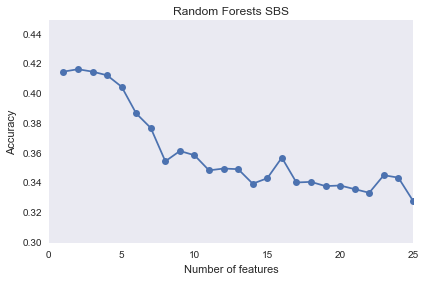

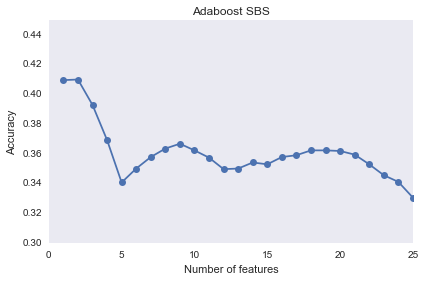

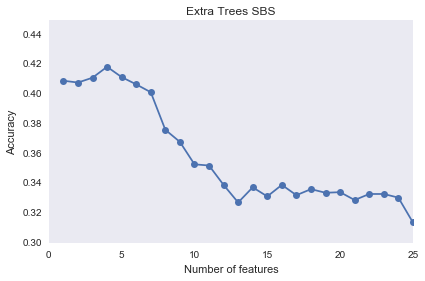

In [184]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

# we want to predict the X and y data as follows:
# We've put the target as the first attribute to easily assign:
X, y = train_booked_df.iloc[:, 1:].values, train_booked_df.iloc[:, 0].values

# we are sampling way down to improve performance (~12,000 records):
sss = StratifiedShuffleSplit(y, 1, test_size=0.006, train_size=0.024, random_state=0)

dt_stump = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)

stdsc = StandardScaler()

for train_index, test_index in sss:
    X_train_std, X_test_std = stdsc.fit_transform(X[train_index]), stdsc.fit_transform(X[test_index])
    y_train, y_test = y[train_index], y[test_index]

# Reduce # of estimators for efficiency during feature selection exercises.
rf = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)

# selecting features
sbs_rf = SBS(rf, k_features=1)
sbs_rf.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat_rf = [len(k) for k in sbs_rf.subsets_]

# Reduce # of estimators for efficiency during feature selection exercises.
ada = AdaBoostClassifier(base_estimator=dt_stump,algorithm="SAMME.R",
                       learning_rate=0.4, n_estimators=10)

# selecting features
sbs_ada = SBS(ada, k_features=1)
sbs_ada.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat_ada = [len(k) for k in sbs_ada.subsets_]

# Reduce # of estimators for efficiency during feature selection exercises.
et = ExtraTreesClassifier(n_estimators=10,min_samples_split=2)

# selecting features
sbs_et = SBS(et, k_features=1)
sbs_et.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat_et = [len(k) for k in sbs_et.subsets_]

plt.plot(k_feat_rf, sbs_rf.scores_, marker='o')
plt.title('Random Forests SBS')
plt.ylim([0.3, 0.45])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(k_feat_ada, sbs_ada.scores_, marker='o')
plt.title('Adaboost SBS')
plt.ylim([0.3, 0.45])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(k_feat_et, sbs_et.scores_, marker='o')
plt.title('Extra Trees SBS')
plt.ylim([0.3, 0.45])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [185]:
# Display individual accuracy scores for each feature subset:
from sets import Set

print("Random Forests SBS Feature Importances:")
print
print("index) , [accuracy] , [feature count] , [feature removed (SBS)] ")

for f in range(X.shape[1]):
    set1 = Set(sbs_rf.subsets_[f])
    if f < X.shape[1] - 1:
        set2 = Set(sbs_rf.subsets_[f + 1])
        k = set1.difference(set2).pop()
    else:
        k = sbs_rf.subsets_[f]
   
    print("%2d) , %-*s , %i , %s" % (f, 10, 
                            sbs_rf.scores_[f], 
                            k_feat[f],
                            train_booked_df.columns[1:][k]))

Random Forests SBS Feature Importances:

index) , [accuracy] , [feature count] , [feature removed (SBS)] 
 0) , 0.328315703824 , 25 , cnt
 1) , 0.343775427177 , 24 , hotel_continent
 2) , 0.345402766477 , 23 , srch_children_cnt
 3) , 0.33360455655 , 22 , booking_window
 4) , 0.3360455655 , 21 , channel
 5) , 0.338486574451 , 20 , user_id
 6) , 0.338079739626 , 19 , is_booking
 7) , 0.340927583401 , 18 , user_location_country
 8) , 0.340520748576 , 17 , site_name
 9) , 0.357200976404 , 16 , ci_week
10) , 0.343368592352 , 15 , srch_adults_cnt
11) , 0.339707078926 , 14 , srch_rm_cnt
12) , 0.349471114727 , 13 , srch_week
13) , 0.349877949552 , 12 , srch_destination_type_id
14) , 0.348657445077 , 11 , user_location_city
15) , 0.358828315704 , 10 , user_location_region
16) , 0.361676159479 , 9 , length_of_stay
17) , 0.354759967453 , 8 , orig_destination_distance
18) , 0.377135882832 , 7 , family_size
19) , 0.386899918633 , 6 , is_mobile
20) , 0.404800650936 , 5 , posa_continent
21) , 0.41253

In [186]:
# Display individual accuracy scores for each feature subset:
print("Adaboost SBS Feature Importances:")
print
print("index) , [accuracy] , [feature count] , [feature removed (SBS)] ")

for f in range(X.shape[1]):
    set1 = Set(sbs_ada.subsets_[f])
    if f < X.shape[1] - 1:
        set2 = Set(sbs_ada.subsets_[f + 1])
        k = set1.difference(set2).pop()
    else:
        k = sbs_ada.subsets_[f]
   
    print("%2d) , %-*s , %i , %s" % (f, 10, 
                            sbs_ada.scores_[f], 
                            k_feat[f],
                            train_booked_df.columns[1:][k]))

Adaboost SBS Feature Importances:

index) , [accuracy] , [feature count] , [feature removed (SBS)] 
 0) , 0.33034987795 , 25 , user_location_city
 1) , 0.340927583401 , 24 , user_id
 2) , 0.345402766477 , 23 , ci_week
 3) , 0.352725793328 , 22 , is_package
 4) , 0.359235150529 , 21 , cnt
 5) , 0.361676159479 , 20 , srch_adults_cnt
 6) , 0.362082994304 , 19 , is_booking
 7) , 0.362082994304 , 18 , site_name
 8) , 0.358828315704 , 17 , srch_rm_cnt
 9) , 0.357607811229 , 16 , length_of_stay
10) , 0.352725793328 , 15 , is_mobile
11) , 0.353946297803 , 14 , srch_destination_type_id
12) , 0.349877949552 , 13 , srch_week
13) , 0.349471114727 , 12 , user_location_country
14) , 0.357200976404 , 11 , user_location_region
15) , 0.362082994304 , 10 , posa_continent
16) , 0.36655817738 , 9 , srch_children_cnt
17) , 0.363303498779 , 8 , hotel_country
18) , 0.357607811229 , 7 , hotel_continent
19) , 0.349877949552 , 6 , family_size
20) , 0.340520748576 , 5 , booking_window
21) , 0.36899918633 , 4 , o

In [187]:
# Display individual accuracy scores for each feature subset:
print("Extra Trees SBS Feature Importances:")
print
print("index) , [accuracy] , [feature count] , [feature removed (SBS)] ")

for f in range(X.shape[1]):
    set1 = Set(sbs_et.subsets_[f])
    if f < X.shape[1] - 1:
        set2 = Set(sbs_et.subsets_[f + 1])
        k = set1.difference(set2).pop()
    else:
        k = sbs_et.subsets_[f]
   
    print("%2d) , %-*s , %i , %s" % (f, 10, 
                            sbs_et.scores_[f], 
                            k_feat[f],
                            train_booked_df.columns[1:][k]))

Extra Trees SBS Feature Importances:

index) , [accuracy] , [feature count] , [feature removed (SBS)] 
 0) , 0.313669650122 , 25 , channel
 1) , 0.33034987795 , 24 , cnt
 2) , 0.3327908869 , 23 , length_of_stay
 3) , 0.3327908869 , 22 , posa_continent
 4) , 0.328722538649 , 21 , is_mobile
 5) , 0.334011391375 , 20 , srch_children_cnt
 6) , 0.33360455655 , 19 , is_booking
 7) , 0.3360455655 , 18 , user_location_city
 8) , 0.33197721725 , 17 , site_name
 9) , 0.338893409276 , 16 , user_location_region
10) , 0.3311635476 , 15 , user_id
11) , 0.337266069976 , 14 , user_location_country
12) , 0.327095199349 , 13 , srch_adults_cnt
13) , 0.338893409276 , 12 , srch_week
14) , 0.351912123678 , 11 , ci_week
15) , 0.352725793328 , 10 , orig_destination_distance
16) , 0.367778681855 , 9 , booking_window
17) , 0.375915378356 , 8 , family_size
18) , 0.40113913751 , 7 , srch_rm_cnt
19) , 0.406427990236 , 6 , is_package
20) , 0.411310008137 , 5 , hotel_continent
21) , 0.418226200163 , 4 , hotel_countr

### SBS Features (RF):
We can see in the graph and the scores that the best accuracy results come from including between 1-4 features. 
### SBS Features (Ada):
We can see in the graph and the scores that the best accuracy results come from including between 1-2 features. 
### SBS Features (ET):
We can see in the graph and the scores that the best accuracy results come from including between 1-5 features. 
### Sequential Backward Selection Conclusions:
SBS consistently settles on 1-5 features that lead to the best model accuracy. What seems to be clear is that some hotel location feature (continent, country, market) are important. Also consistent among these algorithms is srch_destination_id. So far if we were to choose two features that are most important from SBS tests they would be hotel_market and srch_destination_id.
### Feature Importance Functions:
All three of the algorithms in our classification task automatically calculate feature_importances. We're going to asses these and see how they compare to the two features we like from SBS:

 1) hotel_market                   0.107868
 2) srch_destination_id            0.102026
 3) orig_destination_distance      0.097856
 4) user_id                        0.093783
 5) user_location_city             0.087022
 6) srch_week                      0.074021
 7) ci_week                        0.072787
 8) booking_window                 0.071516
 9) user_location_region           0.065946
10) channel                        0.031236
11) length_of_stay                 0.029644
12) hotel_country                  0.025501
13) hotel_continent                0.023168
14) family_size                    0.020228
15) srch_adults_cnt                0.016330
16) srch_destination_type_id       0.016299
17) user_location_country          0.013750
18) site_name                      0.011180
19) srch_children_cnt              0.011137
20) is_mobile                      0.009880
21) srch_rm_cnt                    0.008252
22) posa_continent                 0.004415
23) is_package                  

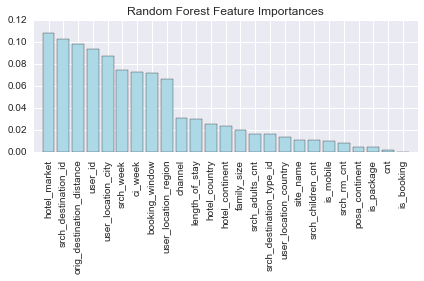

In [114]:
feat_labels = train_booked_df.columns[1:]

rf = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1)

rf.fit(X, y)
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Random Forest Feature Importances')
plt.bar(range(X.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

### Feature Importances (Function of Algorithm) (RF):
Once again hotel market and search destination id lead the pack, just as we saw in the SBS graphs. We left is_booking in the model as somewhat of a litmus test for the power of the importance suggestions. We already know is_booking is all 1s since in our high level cleanse excluded all non-booked records. So this variable shouldn't tell us anything. The Random Forest algorithm correctly places is last in terms of importance which is exactly what we wanted to see.

 1) hotel_market                   0.108969
 2) user_location_city             0.106455
 3) user_location_region           0.100877
 4) booking_window                 0.084865
 5) ci_week                        0.083917
 6) srch_destination_id            0.080048
 7) srch_week                      0.078335
 8) user_id                        0.070559
 9) user_location_country          0.052413
10) hotel_continent                0.043815
11) length_of_stay                 0.042488
12) orig_destination_distance      0.030235
13) hotel_country                  0.029709
14) channel                        0.016506
15) family_size                    0.015698
16) posa_continent                 0.011293
17) srch_children_cnt              0.010749
18) srch_destination_type_id       0.010269
19) site_name                      0.008092
20) srch_adults_cnt                0.005828
21) srch_rm_cnt                    0.005000
22) is_mobile                      0.002285
23) is_package                  

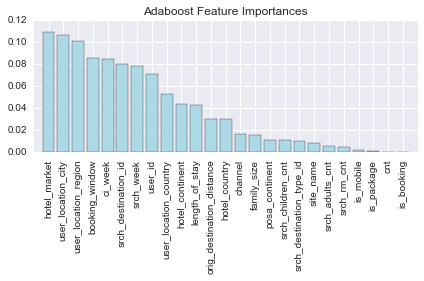

In [113]:
feat_labels = train_booked_df.columns[1:]


ada = AdaBoostClassifier(base_estimator=dt_stump,algorithm="SAMME.R",
                       learning_rate=0.4, n_estimators=10)

ada.fit(X, y)
importances = ada.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Adaboost Feature Importances')
plt.bar(range(X.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
#plt.savefig('./ada.png', dpi=300)
plt.show()

### Feature Importances (Function of Algorithm) (Ada):
Hotel market dominates once again with 2 user based variables and booking window next. Adaboost definately places more importance on user location city, but the other two algorithms place this feature in the top 5 as well. Is_booking is at the end where we want it.

 1) hotel_country                  0.106656
 2) srch_destination_id            0.088188
 3) srch_week                      0.086904
 4) user_id                        0.078623
 5) user_location_city             0.075310
 6) length_of_stay                 0.074013
 7) ci_week                        0.072160
 8) hotel_market                   0.071601
 9) user_location_region           0.067217
10) srch_rm_cnt                    0.044678
11) channel                        0.037557
12) orig_destination_distance      0.029546
13) family_size                    0.026036
14) is_booking                     0.023430
15) hotel_continent                0.020580
16) srch_destination_type_id       0.019522
17) srch_adults_cnt                0.017827
18) user_location_country          0.014186
19) srch_children_cnt              0.013953
20) is_mobile                      0.011587
21) site_name                      0.011321
22) posa_continent                 0.005780
23) is_package                  

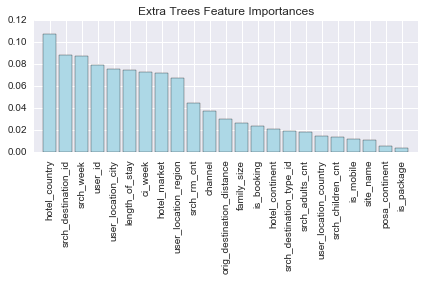

In [174]:
feat_labels = train_booked_df.columns[1:]


et = ExtraTreesClassifier(n_estimators=10,min_samples_split=2)

et.fit(X, y)
importances = et.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Extra Trees Feature Importances')
plt.bar(range(X.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
#plt.savefig('./ada.png', dpi=300)
plt.show()

### Feature Importances (Function of Algorithm) (ET):
Extra trees shakes things up a bit. This algorithm is the first to drop hotel market from the top 3. Instead we see that hotel country takes its place. Search destination ID is familiar at the top of the feature importances list. Is_booking is given more importance than we would expect, perhaps due to the random nature of decision trees selections during initialization.

In [3]:
# Both Random Forest and Adaboost show is_booking to be unimportant. Since we've confirmed this in these
# analyses and we know it to make intuitive sense, we'll drop it from our data.
train_booked_df.drop(['is_booking'], axis=1, inplace=True)

### Feature Selection Conclusions:
We've been able to learn a lot about how different features impact our models in general, and which have specific impacts to each individual algorithm. By far the most consistently important feature is hotel_market. This will be included in any feature subset as well as srch_destination_id. We now take these findings and create a variety of feature subset dataframes that we can continue to experiment with throughout the rest of this analysis:
### Feature Subset Dataframes:

In [4]:
# Create reduced df based on most important features from our algorithms' important features function.
# The feature importance threshold is 9% to be included:
reduced_df1 = train_booked_df[['hotel_cluster','hotel_market','srch_destination_id','orig_destination_distance',
                            'user_id','user_location_city','user_location_region','hotel_country']]

Let's also create the simplest model using only the two most consistently important variables across all models:

In [5]:
# These features yielded the best performance in SBS:
reduced_df2 = train_booked_df[['hotel_cluster','hotel_market','srch_destination_id']]

# randomforest_df2 = train_booked_df[['hotel_cluster','hotel_market','srch_destination_id','hotel_country']]

## Modeling and Evaluation
### Training/Testing Split Strategy
All 3 of the machine learning algorithms we are using are quite computationally expensive on 400,000 records. Based on this fact we are sampling way down to improve performance by taking approximately 30,000 records. We're using stratified shuffle split to easily sub-sample by our class proportions even though we don't really care about the test data since we'll be using stratified k-fold next just on what we get in the training set. Since we are initially tackling a classification.
### Evaluation Metrics: Classification Task
For our evaluation metric we are using accuracy in order to help us decide which is the best model to choose. We are using a classification model to distinguish which features will build the best model for picking the correct cluster.  Since the clusters are masked we do not care to actually classify each of the variables into one cluster or another but rather determine the correct cluster.  So in this case the accuracy of our score will let us know how well we created a model that predicted which cluster is chosen.  
We debated looking at recall and precision but determined that it wasn't essential to our business problem. Accuracy really drives this analysis.  Precision and recall would give us the true positives divided by the false positives and true positives divided by the false negative respectively, however in this model hotel cluster selection is not a life or death issue like it might in a cancer study of giving someone a false positive.  In order to win the kaggle competition we are trying to find the model that best predicts the most true postives which is ultimately acquired through accuracy. 
### Modeling: Classification Task

In [6]:
# we want to predict the X and y data as follows:
# We've put the target as the first attribute to easily assign:
X, y = train_booked_df.iloc[:, 1:].values, train_booked_df.iloc[:, 0].values

# feature subsets:
X1, y1 = reduced_df1.iloc[:, 1:].values, reduced_df1.iloc[:, 0].values
X2, y2 = reduced_df2.iloc[:, 1:].values, reduced_df2.iloc[:, 0].values

# This takes a stratified sample of 10% of our total dataset:
cv_object = StratifiedShuffleSplit(y, n_iter=1, test_size=0.0001, train_size=0.0699)
cv_object1 = StratifiedShuffleSplit(y1, n_iter=1, test_size=0.0001, train_size=0.0699)
cv_object2 = StratifiedShuffleSplit(y2, n_iter=1, test_size=0.0001, train_size=0.0699)

stdsc = StandardScaler()
  
# Now we
for train_index, test_index in cv_object:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
for train_index, test_index in cv_object1:
    X_train1, X_test1 = X1[train_index], X1[test_index]
    y_train1, y_test1 = y1[train_index], y1[test_index]
    
for train_index, test_index in cv_object2:
    X_train2, X_test2 = X2[train_index], X2[test_index]
    y_train2, y_test2 = y2[train_index], y2[test_index]

### Parameter optimization
This section documents the trial and error that helped us arrive at an optimized model for our three algorithms. To streamline this process we made use of the GridSearchCV function in sklearn which allows us to tune hyperparameters more efficiently by iterating through different options. In the example below you can see how we've tuned our random forest model to determine the best max_depth(100), n_estimators(100), criterion('entropy'), and class_weight('balanced').

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier())])

param_range = [1, 2, 3, 5, 10, 20, 50, 100]

param_grid = [{'clf__max_depth': param_range, 
               'clf__class_weight': ['balanced_subsample'],
               'clf__criterion': ['gini']},
                 {'clf__max_depth': param_range,
                  'clf__n_estimators': param_range, 
                  'clf__class_weight': ['balanced'],
                  'clf__criterion': ['entropy']}]

gs = GridSearchCV(estimator=pipe_rf, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.404155753449
{'clf__criterion': 'entropy', 'clf__max_depth': 50, 'clf__class_weight': 'balanced', 'clf__n_estimators': 100}


### Parameter optimization (cont'd)
We apply the same gridsearch methodology to our other two algorithms to tune our parameters:

In [29]:
pipe_ada = Pipeline([('scl', StandardScaler()),
                    ('clf', AdaBoostClassifier())])

param_range1 = [1, 2, 3, 5, 10, 20, 50, 100]
param_range2 = [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9]

param_grid = [{'clf__n_estimators': param_range1,
               'clf__learning_rate': param_range2,
               'clf__algorithm': ['SAMME.R']},
                 {'clf__n_estimators': param_range1, 
                  'clf__learning_rate': param_range2,
                  'clf__algorithm': ['SAMME']}]

gs = GridSearchCV(estimator=pipe_ada, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.380757813864
{'clf__learning_rate': 0.9, 'clf__algorithm': 'SAMME.R', 'clf__n_estimators': 100}


In [30]:
pipe_et = Pipeline([('scl', StandardScaler()),
                    ('clf', ExtraTreesClassifier())])

param_range1 = [1, 2, 3, 5, 10, 20, 50, 100]
param_range2 = [1, 2, 3]

param_grid = [{'clf__max_depth': param_range1, 
               'clf__min_samples_split': param_range2,
               'clf__class_weight': ['balanced_subsample'],
               'clf__criterion': ['gini']},
                 {'clf__max_depth': param_range1,
                  'clf__n_estimators': param_range1, 
                  'clf__min_samples_split': param_range2,
                  'clf__class_weight': ['balanced'],
                  'clf__criterion': ['entropy']}]

gs = GridSearchCV(estimator=pipe_et, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.388440719399
{'clf__criterion': 'entropy', 'clf__max_depth': 50, 'clf__class_weight': 'balanced', 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


### Random Forest Model - Full Dataset

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import StratifiedKFold

pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(max_depth=50, n_estimators=100, criterion='entropy', 
                                                   n_jobs=-1, class_weight='balanced'))])

kfold = StratifiedKFold(y=y_train, 
                        n_folds=10,
                        random_state=0)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_rf.fit(X_train[train], y_train[train])
    score = pipe_rf.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Acc: %.3f' % (k+1, score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.400
Fold: 2, Acc: 0.402
Fold: 3, Acc: 0.405
Fold: 4, Acc: 0.409
Fold: 5, Acc: 0.397
Fold: 6, Acc: 0.403
Fold: 7, Acc: 0.395
Fold: 8, Acc: 0.400
Fold: 9, Acc: 0.402
Fold: 10, Acc: 0.405

CV accuracy: 0.402 +/- 0.004


### Adaboost Model - Full Dataset

In [31]:
dt_stump = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)

pipe_ada = Pipeline([('scl', StandardScaler()),
                    ('clf', AdaBoostClassifier(base_estimator=dt_stump,algorithm="SAMME.R", 
                          learning_rate=0.9, n_estimators=100))])

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_ada.fit(X_train[train], y_train[train])
    score = pipe_ada.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Acc: %.3f' % (k+1, score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.376
Fold: 2, Acc: 0.356
Fold: 3, Acc: 0.380
Fold: 4, Acc: 0.384
Fold: 5, Acc: 0.386
Fold: 6, Acc: 0.365
Fold: 7, Acc: 0.373
Fold: 8, Acc: 0.384
Fold: 9, Acc: 0.375
Fold: 10, Acc: 0.388

CV accuracy: 0.377 +/- 0.010


### Extra Trees Model - Full Dataset

In [34]:
pipe_et = Pipeline([('scl', StandardScaler()),
                    ('clf', ExtraTreesClassifier(max_depth=50, n_estimators=100, min_samples_split=2,
                                                 criterion='entropy', class_weight='balanced'))])

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_et.fit(X_train[train], y_train[train])
    score = pipe_et.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Acc: %.3f' % (k+1, score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.394
Fold: 2, Acc: 0.370
Fold: 3, Acc: 0.387
Fold: 4, Acc: 0.392
Fold: 5, Acc: 0.393
Fold: 6, Acc: 0.382
Fold: 7, Acc: 0.391
Fold: 8, Acc: 0.385
Fold: 9, Acc: 0.380
Fold: 10, Acc: 0.392

CV accuracy: 0.387 +/- 0.007


### Model performance after optimization:
Just through model parameter changes we've been able to improve our accuracy score by 1-2% over anything using logistic regression or SVM in the MiniLab. But this is on the full dataset. We would expect the feature subsets to perform even better on data containing the most important features that we determined in preprocessing.
### Random Forest Model - Feature Subset 1: (Feature Importances Algorithm):

In [36]:
kfold = StratifiedKFold(y=y_train1, 
                        n_folds=10,
                        random_state=0)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_rf.fit(X_train1[train], y_train1[train])
    score = pipe_rf.score(X_train1[test], y_train1[test])
    scores.append(score)
 
print('Random Forest Score:')
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Random Forest Score:

CV accuracy: 0.419 +/- 0.005


### Adaboost Model - Feature Subset 1: (Feature Importances Algorithm):
Please note that after several attempts this model doesn't run on this data subset. Adaboost is the slowest algorithm of the 3, so this shortfall will be noted in the assessment.

In [ ]:
# DO NOT RUN THIS CODE. IT DOESN'T STOP.

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_ada.fit(X_train1[train], y_train1[train])
    score = pipe_ada.score(X_train1[test], y_train1[test])
    scores.append(score)
 
print('Adaboost Score:')
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

### Extra Trees Model - Feature Subset 1: (Feature Importances Algorithm):

In [37]:
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_et.fit(X_train1[train], y_train1[train])
    score = pipe_et.score(X_train1[test], y_train1[test])
    scores.append(score)
 
print('Extra Trees Score:')
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Extra Trees Score:

CV accuracy: 0.400 +/- 0.009


By just focusing on the features that make up a high percentage of feature importance based on our three algorithms we've added another 2-3% to our accuracy.
### Random Forest Model - Feature Subset 2: Simplest Features (hotel_market, search_dest_id):

In [38]:
kfold = StratifiedKFold(y=y_train2, 
                        n_folds=10,
                        random_state=0)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_rf.fit(X_train2[train], y_train2[train])
    score = pipe_rf.score(X_train2[test], y_train2[test])
    scores.append(score)
 
print('Random Forest Score:')
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py

Random Forest Score:

CV accuracy: 0.490 +/- 0.017


/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Adaboost Model - Feature Subset 2: Simplest Features (hotel_market, search_dest_id):

In [39]:
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_ada.fit(X_train2[train], y_train2[train])
    score = pipe_ada.score(X_train2[test], y_train2[test])
    scores.append(score)
 
print('Adaboost Score:')
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py

Adaboost Score:

CV accuracy: 0.464 +/- 0.015


/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Extra Trees Model - Feature Subset 2: Simplest Features (hotel_market, search_dest_id):

In [40]:
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_et.fit(X_train2[train], y_train2[train])
    score = pipe_et.score(X_train2[test], y_train2[test])
    scores.append(score)
 
print('Extra Trees Score:')
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py

Extra Trees Score:

CV accuracy: 0.489 +/- 0.016


/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Statistical Comparison of Models

In [41]:
# This code will return arrays containing the k-fold scores.

from sklearn.cross_validation import cross_val_score

kfold = StratifiedKFold(y=y_train, 
                        n_folds=10,
                        random_state=1)

# Scores for the full dataset:
rf_acc1 = cross_val_score(pipe_rf, X_train, y=y_train, cv=kfold)
ada_acc1 = cross_val_score(pipe_et, X_train, y=y_train, cv=kfold)
et_acc1 = cross_val_score(pipe_et, X_train, y=y_train, cv=kfold)

# Scores for the intermediary data subset are excluded because adaboost could not be run.

# Scores for the smallest data subset:
rf_acc2 = cross_val_score(pipe_rf, X_train2, y=y_train2, cv=kfold)
ada_acc2 = cross_val_score(pipe_et, X_train2, y=y_train2, cv=kfold)
et_acc2 = cross_val_score(pipe_et, X_train2, y=y_train2, cv=kfold)

/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/danielmurphy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py

In [42]:
full_scores = [['Random Forest',np.mean(rf_acc1)],['Adaboost',np.mean(ada_acc1)],['Extra Trees',np.mean(et_acc1)]]

for x in range(0, len(full_scores)):
    print('\nFull Model: %s = %.3f' % (full_scores[x][0], full_scores[x][1]))

reduced_scores = [['Random Forest',np.mean(rf_acc2)],['Adaboost',np.mean(ada_acc2)],['Extra Trees',np.mean(et_acc2)]]

print
for x in range(0, len(reduced_scores)):
    print('\nReduced Model: %s = %.3f' % (reduced_scores[x][0], reduced_scores[x][1]))


Full Model: Random Forest = 0.404

Full Model: Adaboost = 0.389

Full Model: Extra Trees = 0.386


Reduced Model: Random Forest = 0.490

Reduced Model: Adaboost = 0.488

Reduced Model: Extra Trees = 0.489


### Best performing model:
We can see in the CV mean scores that Random Forest achieved the highest accuracy when using the full dataset and Adaboost and Extra Tress are tied on the reduced set. Let's put some more formal statistics around these results:

In [44]:
from scipy import stats
import numpy as np, statsmodels.stats.api as sms

rf_ada_ttest1 = stats.ttest_ind(rf_acc1, ada_acc1)
ada_et_ttest1 = stats.ttest_ind(ada_acc1, et_acc1)
rf_et_ttest1 = stats.ttest_ind(rf_acc1, et_acc1)

rf_ada_CI1 = sms.CompareMeans(sms.DescrStatsW(rf_acc1), sms.DescrStatsW(ada_acc1))
ada_et_CI1 = sms.CompareMeans(sms.DescrStatsW(ada_acc1), sms.DescrStatsW(et_acc1))
rf_et_CI1 = sms.CompareMeans(sms.DescrStatsW(rf_acc1), sms.DescrStatsW(et_acc1))
rf_ada_CI1 = rf_ada_CI1.tconfint_diff()
ada_et_CI1 = ada_et_CI1.tconfint_diff()
rf_et_CI1 = rf_et_CI1.tconfint_diff()

full_stats = [['Random Forest v. Adaboost',rf_ada_ttest1,rf_ada_CI1],
             ['Adaboost v. Extra Trees',ada_et_ttest1,ada_et_CI1],
             ['Random Forest v. Extra Trees',rf_et_ttest1,rf_et_CI1]]

rf_ada_ttest2 = stats.ttest_ind(rf_acc2, ada_acc2)
ada_et_ttest2 = stats.ttest_ind(ada_acc2, et_acc2)
rf_et_ttest2 = stats.ttest_ind(rf_acc2, et_acc2)

rf_ada_CI2 = sms.CompareMeans(sms.DescrStatsW(rf_acc2), sms.DescrStatsW(ada_acc2))
ada_et_CI2 = sms.CompareMeans(sms.DescrStatsW(ada_acc2), sms.DescrStatsW(et_acc2))
rf_et_CI2 = sms.CompareMeans(sms.DescrStatsW(rf_acc2), sms.DescrStatsW(et_acc2))
rf_ada_CI2 = rf_ada_CI2.tconfint_diff()
ada_et_CI2 = ada_et_CI2.tconfint_diff()
rf_et_CI2 = rf_et_CI2.tconfint_diff()

reduced_stats = [['Random Forest v. Adaboost',rf_ada_ttest2,rf_ada_CI2],
                 ['Adaboost v. Extra Trees',ada_et_ttest2,ada_et_CI2],
                 ['Random Forest v. Extra Trees',rf_et_ttest2,rf_et_CI2]]
print('Full Dataset Statistical Comparison')
print
for x in range(0, len(full_stats)):
    print('%s: p-value: %f Confidence Interval: %s' % (full_stats[x][0], full_stats[x][1][1], full_stats[x][2]))
print
print('Reduced Dataset Statistical Comparison')
print
for x in range(0, len(reduced_stats)):
    print('%s: p-value: %f Confidence Interval: %s' % (reduced_stats[x][0], reduced_stats[x][1][1], reduced_stats[x][2]))



Full Dataset Statistical Comparison

Random Forest v. Adaboost: p-value: 0.003186 Confidence Interval: (0.0055942342292534739, 0.023677290551483217)
Adaboost v. Extra Trees: p-value: 0.379014 Confidence Interval: (-0.0045003401460736274, 0.01127078949387254)
Random Forest v. Extra Trees: p-value: 0.000225 Confidence Interval: (0.0097799427811615137, 0.026262031347374089)

Reduced Dataset Statistical Comparison

Random Forest v. Adaboost: p-value: 0.827801 Confidence Interval: (-0.01517283169419224, 0.018735016578960689)
Adaboost v. Extra Trees: p-value: 0.972794 Confidence Interval: (-0.017249167391974542, 0.016690508191338962)
Random Forest v. Extra Trees: p-value: 0.856493 Confidence Interval: (-0.015696540809699296, 0.018700066493832164)


### Statistical Interpretation

Null hypothesis = Models' means are the same

Random Forest v. Adaboost: Reject Null

Adaboost v. Extra Trees: Fail to Reject

Random Forest v. Extra Trees: Reject Null

On both the full and reduced datasets we see that there is no statistical difference (95% confidence interval) between the means of Adaboost and Extra Trees. On the reduced dataset all models are statistically equal in terms of accuracy.

### Which model to pick?
Based on our results and statistical analysis we are going with Random Forest since it preforms the best on the full dataset and is as statistically accurate as the other two algorithms on the reduced dataset. Random forest is as fast as extra trees and definitely faster than adaboost so it wins in the efficiency category as well.

## Deployment
This classification task is extremely useful for Expedia which is why they submitted this challenge to the Kaggle community in the first place. Knowing hotel_clusters would potentially allow Expedia to customize the user's booking experience with predicted hotels from within the clusters. If the look and feel of the website automatically adjust to the customer's travel destination aesthetic their is a huge potential upside to subliminal behavioral changes that might lead to booking. Other potential applications are targeted advertisements (for non booked user sessions) and more robust customer data/demographic collection for hotels within these clusters to gather. 

If our models were systems ready, we would suggest implementing the model to the site and update the training set on a monthly or quarterly basis (pending testing to fine tune the learning necessity of the model).

### Attribute Assessment: Classification Task
We have already talked at length about attributes that are important to classification tasks for all algorithms.


## Exceptional Work
xtreme gradient boosting has been the winner of a few Kaggle competitions so far so we wanted to take a look at a simplified version to see if we could also implement it on our data set. Ultimately these models can take days to run so we will not go into every detail of xtreme gradient boosting.
Gradient boosting has been a winning model because it can efficiently be run on a cluster and keeps the accuracy on a wide variety of datasets.

Since we are only testing out how the gradient boosting works we are using the out of the box parameters from the scikit-learn website.


In [367]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

pipe_gb = Pipeline([('scl', StandardScaler()),
                    ('clf', GradientBoostingClassifier(max_depth=20, n_estimators=100))])

kfold = StratifiedKFold(y=y_train, 
                        n_folds=10,
                        random_state=0)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_gb.fit(X_train[train], y_train[train])
    score = pipe_gb.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Acc: %.3f' % (k+1, score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.431
Fold: 2, Acc: 0.428
Fold: 3, Acc: 0.434
Fold: 4, Acc: 0.429
Fold: 5, Acc: 0.434
Fold: 6, Acc: 0.440
Fold: 7, Acc: 0.420
Fold: 8, Acc: 0.433
Fold: 9, Acc: 0.441
Fold: 10, Acc: 0.433

CV accuracy: 0.432 +/- 0.006


### Gradient Boosted Trees Results:
Using cross validation (10 fold) was probably not the best idea since it took over 3 hours to run. So on the efficiency and computational resources front this algorithm doesn't perform particularly well. But keep in mind that based on our deployment requirements we might only be training this model quarterly or perhaps twice a year. A few hours, or even a day might be worth the investment since this algorithm also produced the best results, a full 2% higher than our full dataset score using random forest. Due to the time we were not able to optimize hyperparameters in this model so we are unsure whether this score can be improved through tuning. We also expect that using this model on the reduced dataset that generally performs better on our 3 primary algorithms would carry over to improved results with this one, probably tipping us over the 50% threshold.

# Task Two: Regression
### Modeling: Regression Task

In [317]:
regression_df = train_booked_df[['booking_window','hotel_cluster','hotel_market','user_location_city','user_location_region',
'ci_week','srch_destination_id','srch_week','user_id','user_location_country','hotel_continent','length_of_stay',
'orig_destination_distance','hotel_country','channel','family_size','posa_continent','srch_children_cnt',
'srch_destination_type_id','site_name','srch_adults_cnt','srch_rm_cnt','is_mobile','is_package']]


In [318]:
regression_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409662 entries, 0 to 409661
Data columns (total 24 columns):
booking_window               409662 non-null int64
hotel_cluster                409662 non-null int64
hotel_market                 409662 non-null int64
user_location_city           409662 non-null int64
user_location_region         409662 non-null int64
ci_week                      409662 non-null int64
srch_destination_id          409662 non-null int64
srch_week                    409662 non-null int64
user_id                      409662 non-null int64
user_location_country        409662 non-null int64
hotel_continent              409662 non-null int64
length_of_stay               409662 non-null int64
orig_destination_distance    409662 non-null float64
hotel_country                409662 non-null int64
channel                      409662 non-null int64
family_size                  409662 non-null int64
posa_continent               409662 non-null int64
srch_children_cnt   

### Random Forest Regression full data set

In [321]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import clone
from itertools import combinations

X = regression_df.iloc[:, 1:].values
y = regression_df['booking_window'].values
X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
                    test_size = 0.4, 
                    random_state = 1)

forest = RandomForestRegressor(
n_estimators = 100, 
                                criterion = 'mse',
                                random_state = 1,
                                n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train : %.3f, test: %.3f' %(
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 : %.3f, test: %.3f' %(
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train : 65.431, test: 444.622
R^2 : 0.969, test: 0.787


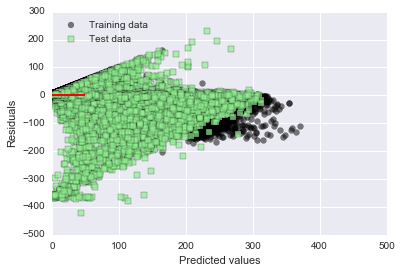

In [322]:
plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='black',
           marker='o',
           s=35,
           alpha = 0.5,
           label = 'Training data')
plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha = 0.7,
           label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax = 50, lw=2, color='red')
plt.xlim([0,500])
plt.show()

### AdaBoost Regression  full data set

In [323]:
from sklearn.tree import DecisionTreeRegressor
X = regression_df.iloc[:, 1:].values
y = regression_df['booking_window'].values
X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
                    test_size = 0.4, 
                    random_state = 1)

ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300)
ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
print('MSE train : %.3f, test: %.3f' %(
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 : %.3f, test: %.3f' %(
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train : 4721.008, test: 4722.481
R^2 : -1.256, test: -1.268


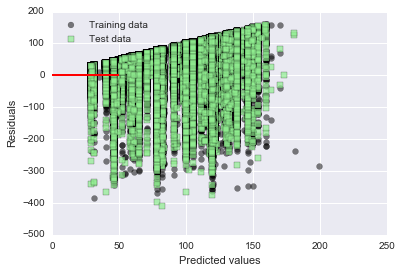

In [324]:
plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='black',
           marker='o',
           s=35,
           alpha = 0.5,
           label = 'Training data')
plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha = 0.7,
           label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax = 50, lw=2, color='red')
plt.xlim([0,250])
plt.show()

### Extra trees Regression  full data set

In [325]:
X = regression_df.iloc[:, 1:].values
y = regression_df['booking_window'].values
X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
                    test_size = 0.4, 
                    random_state = 1)

extra = ExtraTreesRegressor(n_estimators=10, max_features=10,
                                       random_state=0)
extra.fit(X_train, y_train)
y_train_pred = extra.predict(X_train)
y_test_pred = extra.predict(X_test)
print('MSE train : %.3f, test: %.3f' %(
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 : %.3f, test: %.3f' %(
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train : 0.278, test: 827.182
R^2 : 1.000, test: 0.603


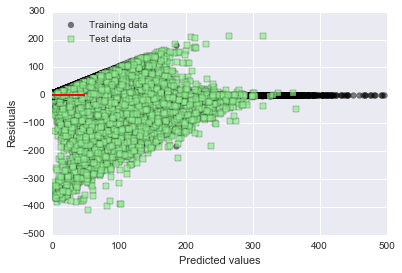

In [326]:
plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='black',
           marker='o',
           s=35,
           alpha = 0.5,
           label = 'Training data')
plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha = 0.7,
           label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax = 50, lw=2, color='red')
plt.xlim([0,500])
plt.show()

### Analysis
These models are over fit since it is using all the features to explain the booking window.  R^2 will always increase when as you add more features.  We need to create a model with the least number of features but still highest R^2.
### Excluding features
We need to reduce the number of features for the regression model in order to find best R^2 with the least amount of features possible.  We will run a simple regression for each feature to see if there is a correlation and include those in the first run. 
We will also only pick one hotel location since it was a repetitive feature.   

In [327]:
regression_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409662 entries, 0 to 409661
Data columns (total 24 columns):
booking_window               409662 non-null int64
hotel_cluster                409662 non-null int64
hotel_market                 409662 non-null int64
user_location_city           409662 non-null int64
user_location_region         409662 non-null int64
ci_week                      409662 non-null int64
srch_destination_id          409662 non-null int64
srch_week                    409662 non-null int64
user_id                      409662 non-null int64
user_location_country        409662 non-null int64
hotel_continent              409662 non-null int64
length_of_stay               409662 non-null int64
orig_destination_distance    409662 non-null float64
hotel_country                409662 non-null int64
channel                      409662 non-null int64
family_size                  409662 non-null int64
posa_continent               409662 non-null int64
srch_children_cnt   

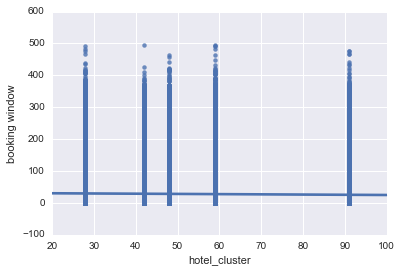

In [328]:
X = train_booked_df[['hotel_cluster']].values
y = train_booked_df['booking_window'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
sns.regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('hotel_cluster')
plt.ylabel('booking window')
plt.show()

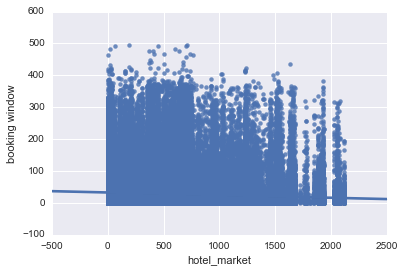

In [329]:
X = train_booked_df[['hotel_market']].values
y = train_booked_df['booking_window'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
sns.regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('hotel_market')
plt.ylabel('booking window')
plt.show()

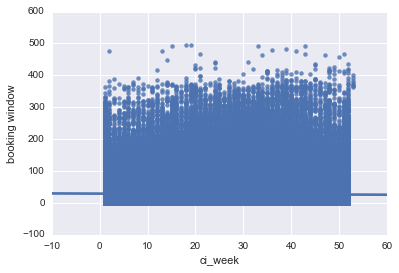

In [330]:
X = train_booked_df[['ci_week']].values
y = train_booked_df['booking_window'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
sns.regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('ci_week')
plt.ylabel('booking window')
plt.show()

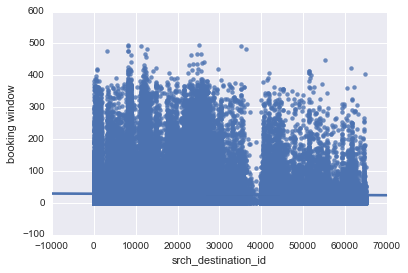

In [331]:
X = train_booked_df[['srch_destination_id']].values
y = train_booked_df['booking_window'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
sns.regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('srch_destination_id')
plt.ylabel('booking window')
plt.show()

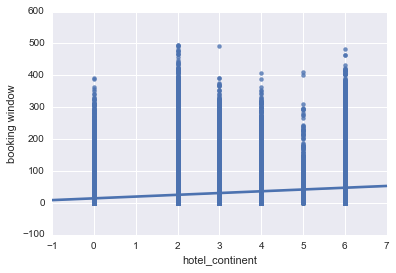

In [332]:
X = train_booked_df[['hotel_continent']].values
y = train_booked_df['booking_window'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
sns.regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('hotel_continent')
plt.ylabel('booking window')
plt.show()

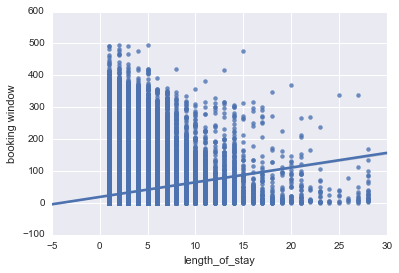

In [333]:
X = train_booked_df[['length_of_stay']].values
y = train_booked_df['booking_window'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
sns.regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('length_of_stay')
plt.ylabel('booking window')
plt.show()

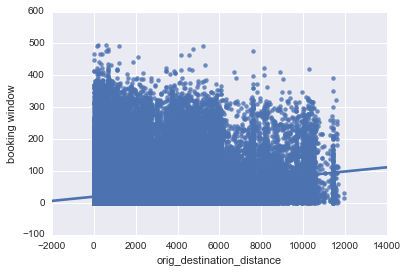

In [334]:
X = train_booked_df[['orig_destination_distance']].values
y = train_booked_df['booking_window'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
sns.regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('orig_destination_distance')
plt.ylabel('booking window')
plt.show()

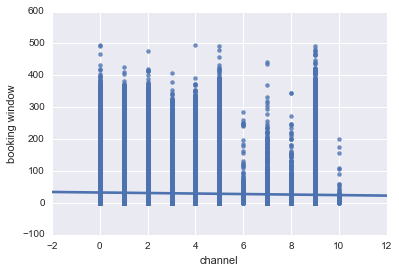

In [335]:
X = train_booked_df[['channel']].values
y = train_booked_df['booking_window'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
sns.regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('channel')
plt.ylabel('booking window')
plt.show()

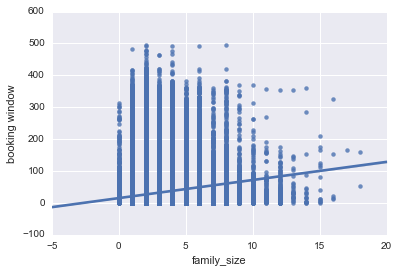

In [336]:
X = train_booked_df[['family_size']].values
y = train_booked_df['booking_window'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
sns.regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('family_size')
plt.ylabel('booking window')
plt.show()

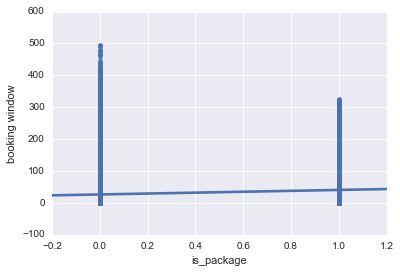

In [337]:
X = train_booked_df[['is_package']].values
y = train_booked_df['booking_window'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
sns.regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('is_package')
plt.ylabel('booking window')
plt.show()

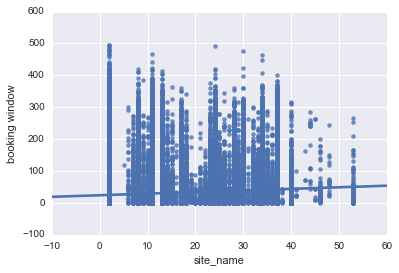

In [338]:
X = train_booked_df[['site_name']].values
y = train_booked_df['booking_window'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
sns.regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('site_name')
plt.ylabel('booking window')
plt.show()

Based on the individual regression models above we also picked length of stay, orig_destination_distance, family  size, and is package since they seemed to have a high correlation with the booking window. 

In [339]:
regression_df1 = train_booked_df[['booking_window', 'orig_destination_distance','length_of_stay', 'family_size', 'hotel_market',
                                 'is_package','posa_continent', 'hotel_country']]

### Random Forest Regression reduced data set

In [340]:
X = regression_df1.iloc[:, 1:].values
y = regression_df1['booking_window'].values
X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
                    test_size = 0.4, 
                    random_state = 1)

forest = RandomForestRegressor(
n_estimators = 100, 
                                criterion = 'mse',
                                random_state = 1,
                                n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train : %.3f, test: %.3f' %(
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 : %.3f, test: %.3f' %(
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train : 515.936, test: 1917.487
R^2 : 0.753, test: 0.079


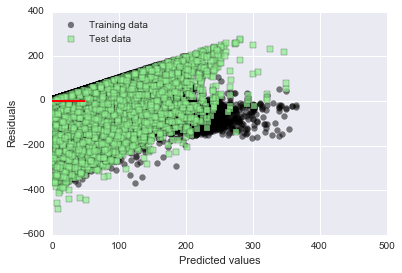

In [341]:
plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='black',
           marker='o',
           s=35,
           alpha = 0.5,
           label = 'Training data')
plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha = 0.7,
           label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax = 50, lw=2, color='red')
plt.xlim([0,500])
plt.show()

### Ada boost Regression reduced data set

In [342]:
from sklearn.tree import DecisionTreeRegressor
X = regression_df1.iloc[:, 1:].values
y = regression_df1['booking_window'].values
X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
                    test_size = 0.4, 
                    random_state = 1)

ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300)
ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
print('MSE train : %.3f, test: %.3f' %(
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 : %.3f, test: %.3f' %(
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train : 5010.842, test: 5010.385
R^2 : -1.395, test: -1.406


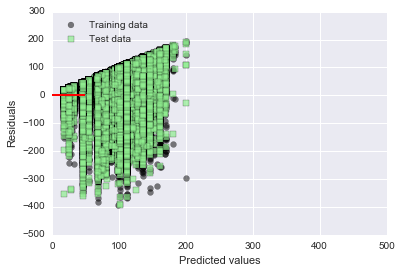

In [343]:
plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='black',
           marker='o',
           s=35,
           alpha = 0.5,
           label = 'Training data')
plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha = 0.7,
           label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax = 50, lw=2, color='red')
plt.xlim([0,500])
plt.show()

### extra trees Regression reduced data set

In [344]:
X = regression_df1.iloc[:, 1:].values
y = regression_df1['booking_window'].values
X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
                    test_size = 0.4, 
                    random_state = 1)

extra = ExtraTreesRegressor(n_estimators=10, max_features=7,
                                       random_state=0)
extra.fit(X_train, y_train)
y_train_pred = extra.predict(X_train)
y_test_pred = extra.predict(X_test)
print('MSE train : %.3f, test: %.3f' %(
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 : %.3f, test: %.3f' %(
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train : 313.827, test: 2253.844
R^2 : 0.850, test: -0.082


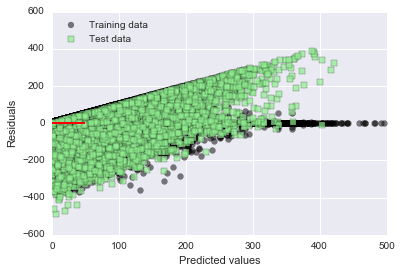

In [345]:
plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='black',
           marker='o',
           s=35,
           alpha = 0.5,
           label = 'Training data')
plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha = 0.7,
           label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax = 50, lw=2, color='red')
plt.xlim([0,500])
plt.show()

### Analysis
These models did not work as there are still too many features. We will reduce the models even more.
### Random Forest Regression Final data set

In [346]:
regression_df1 = train_booked_df[['booking_window', 'orig_destination_distance','length_of_stay', 'family_size', 'hotel_market',
                                 'is_package','posa_continent', 'hotel_country']]

In [347]:
X = regression_df1.iloc[:, 1:].values
y = regression_df1['booking_window'].values
X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
                    test_size = 0.4, 
                    random_state = 1)

forest = RandomForestRegressor(
n_estimators = 100, 
                                criterion = 'mse',
                                random_state = 1,
                                n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train : %.3f, test: %.3f' %(
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 : %.3f, test: %.3f' %(
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train : 515.936, test: 1917.487
R^2 : 0.753, test: 0.079


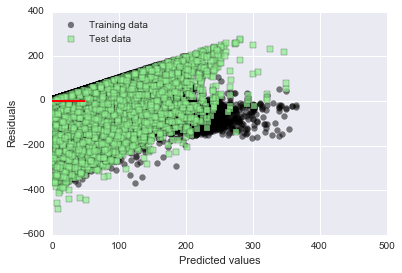

In [348]:
plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='black',
           marker='o',
           s=35,
           alpha = 0.5,
           label = 'Training data')
plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha = 0.7,
           label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax = 50, lw=2, color='red')
plt.xlim([0,500])
plt.show()

### Ada Boost Regression Final data set

In [349]:
regression_df3 = train_booked_df[['booking_window', 'length_of_stay']]

In [350]:
from sklearn.tree import DecisionTreeRegressor
X = regression_df3.iloc[:, 1:].values
y = regression_df3['booking_window'].values
X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
                    test_size = 0.4, 
                    random_state = 1)

ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300)
ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
print('MSE train : %.3f, test: %.3f' %(
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 : %.3f, test: %.3f' %(
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train : 3479.650, test: 3474.594
R^2 : -0.663, test: -0.668


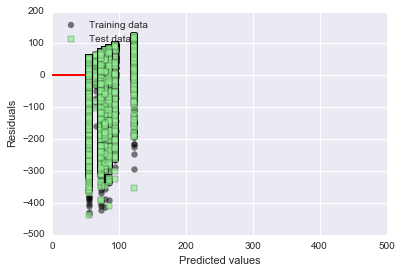

In [351]:
plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='black',
           marker='o',
           s=35,
           alpha = 0.5,
           label = 'Training data')
plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha = 0.7,
           label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax = 50, lw=2, color='red')
plt.xlim([0,500])
plt.show()

### Extra Trees Regression Final data set

In [352]:
regression_df2 = train_booked_df[['booking_window', 'length_of_stay', 'family_size','orig_destination_distance' ]]

In [353]:
X = regression_df2.iloc[:, 1:].values
y = regression_df2['booking_window'].values
X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
                    test_size = 0.4, 
                    random_state = 1)

extra = ExtraTreesRegressor(n_estimators=10, max_features=3,
                                       random_state=0)
extra.fit(X_train, y_train)
y_train_pred = extra.predict(X_train)
y_test_pred = extra.predict(X_test)
print('MSE train : %.3f, test: %.3f' %(
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 : %.3f, test: %.3f' %(
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train : 490.337, test: 2534.491
R^2 : 0.766, test: -0.217


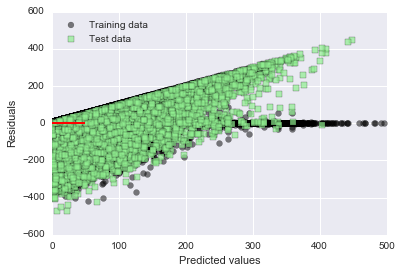

In [354]:
plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='black',
           marker='o',
           s=35,
           alpha = 0.5,
           label = 'Training data')
plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha = 0.7,
           label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax = 50, lw=2, color='red')
plt.xlim([0,500])
plt.show()

## Analysis

The random forest had to increase back up to the 9 feature since the test data set did not match the predictions of the train data set.  The Adaboost model was reduced to one feature length of stay to predict the booking window.  Both the train and test R^2 were between 66% and 67% which is a pretty good prediction for a random data set.  The extra trees regression model for the train data set did not predict the test data set.  

For predicting the booking window the adaboost model using the length of stay feature works best.  

#### Deployment
Expedia can use this model for the future to know how far out someone might be booking by offering them extra insentives after they run a search.  They can remarket each person with a specific deal that might entice them to book rather than waiting until the last minute.  The more that expedia can predict the better their forecasting will be.  